# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [4]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [5]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [6]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [7]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-0.2, 0.2]) # g/cc

In [8]:
model = np.zeros(mesh.n_cells)

for prism, density in zip(prisms, densities, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

(<matplotlib.collections.QuadMesh at 0x7fb7111b4c20>,)

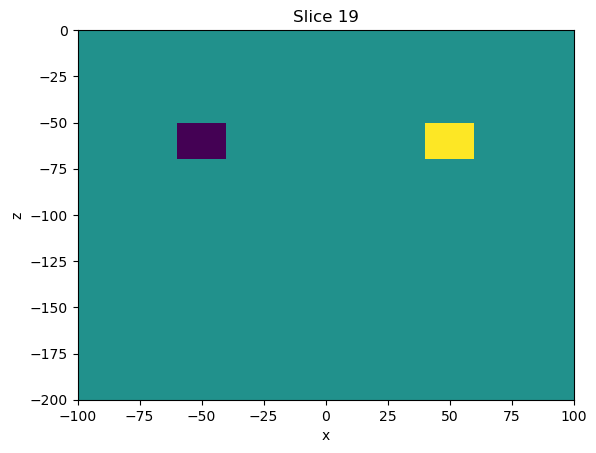

In [9]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [10]:
gz = simulation_simpeg.dpred(model)

In [11]:
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=105).normal(scale=stderr, size=gz.shape)

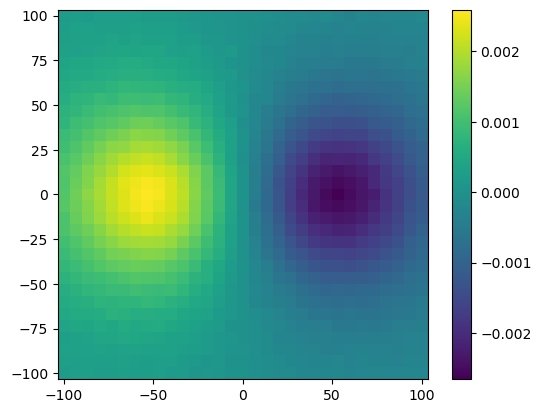

In [12]:
tmp = plt.pcolormesh(*coordinates[:2], gz.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Inversion with new framework

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [13]:
simulation = GravitySimulation(simulation_simpeg)

This `simulation` is _callable_ and has a `jacobian` method, so we can use it with our new framework:

In [14]:
model = np.ones(simulation.n_params)
dpred = simulation(model)

In [15]:
simulation.jacobian(model)

<961x64000 _CustomLinearOperator with dtype=float64>

In [16]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)
data_misfit

φd(m)

In [17]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
smallness = ii.TikhonovZero(
    n_params=simulation.n_params, weights=volume_weights * depth_weights
)
smallness

φs(m)

## Run inversion with beta cooling

In [18]:
# Objective function
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

We can customize the inversion log. Let's add another column:

In [19]:
inversion.log.columns["chi_target hit?"] = lambda _, model: stopping_criteria(model)

In [20]:
model = inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping critiera.


In [21]:
log = pd.DataFrame(inversion.log.log).set_index("iter")
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,chi_target hit?
iter,,,,,,,
0,10000.0,1.669294e+06,0.000000,0.000000,1.669294e+06,1737.038619,False
1,10000.0,9.141177e+03,6.958552,69585.521618,7.872670e+04,9.512151,False
2,5000.0,3.397197e+03,7.739023,38695.114479,4.209231e+04,3.535065,False
3,2500.0,1.410786e+03,8.278338,20695.844005,2.210663e+04,1.468039,False
4,1250.0,6.848553e+02,8.676041,10845.051139,1.152991e+04,0.712649,True


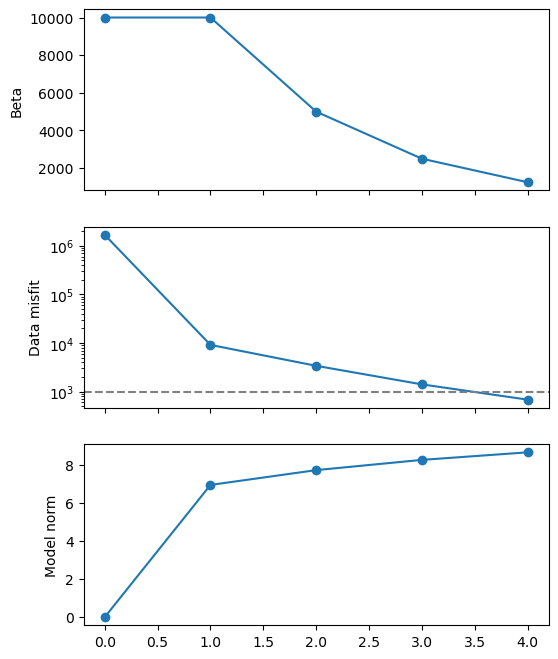

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

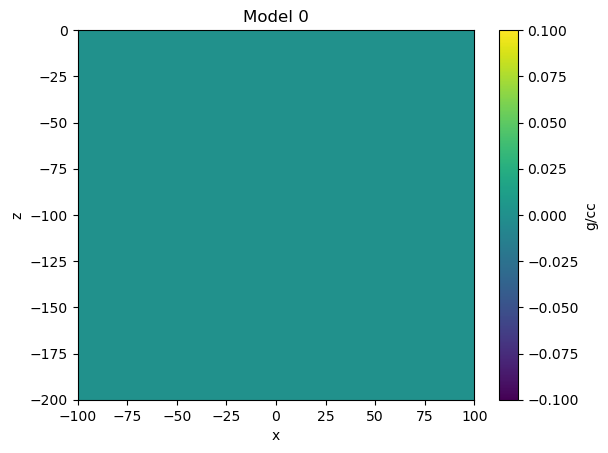

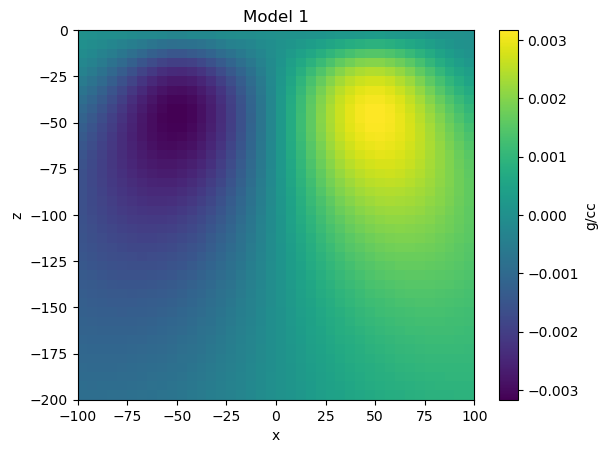

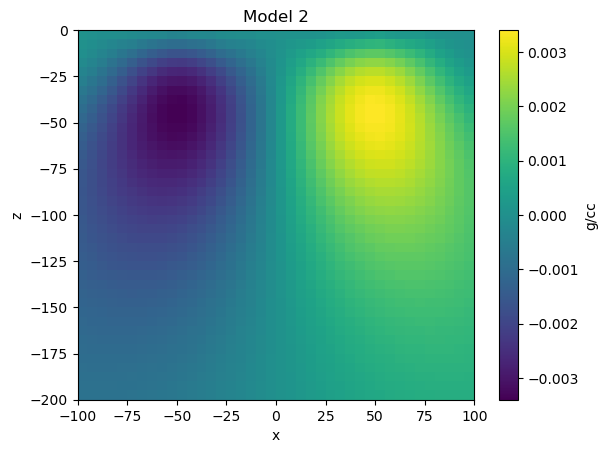

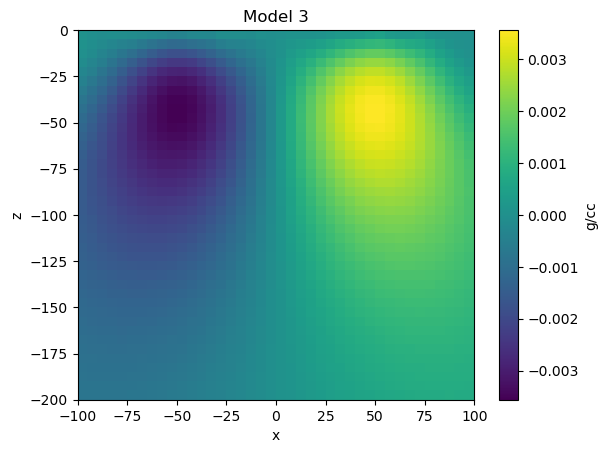

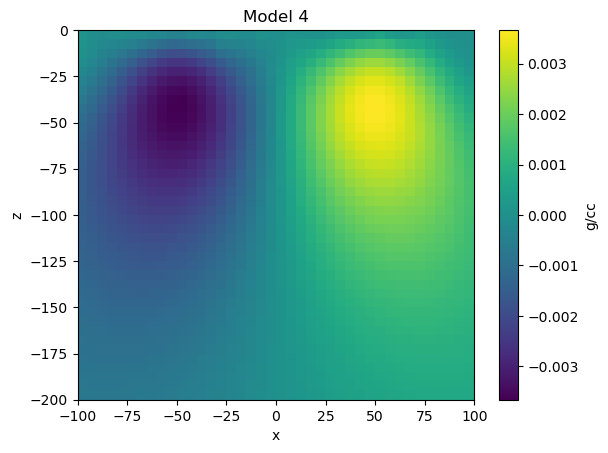

In [23]:
for i, model in enumerate(inversion.models):
    tmp, = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()

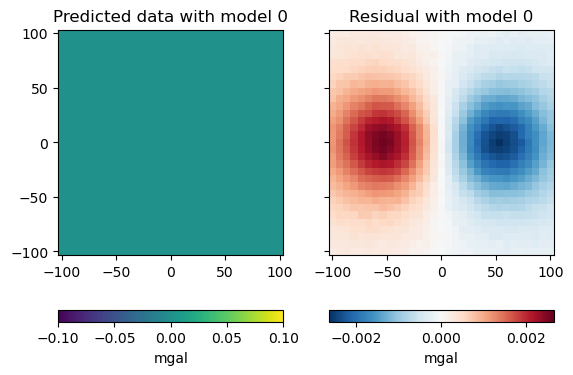

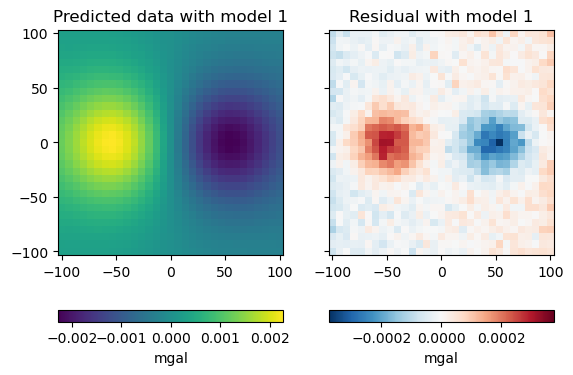

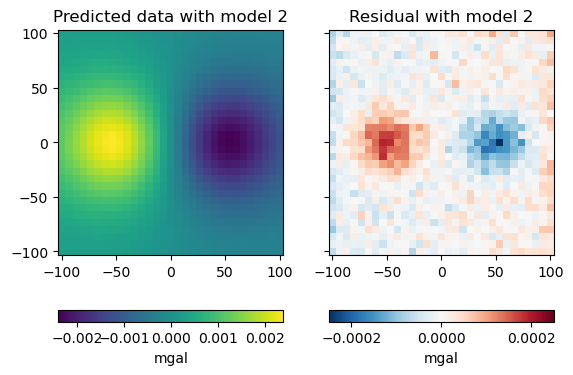

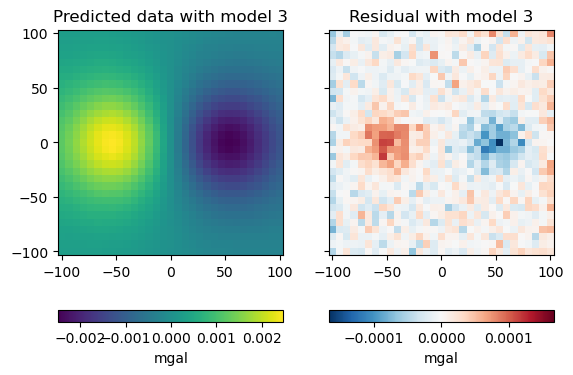

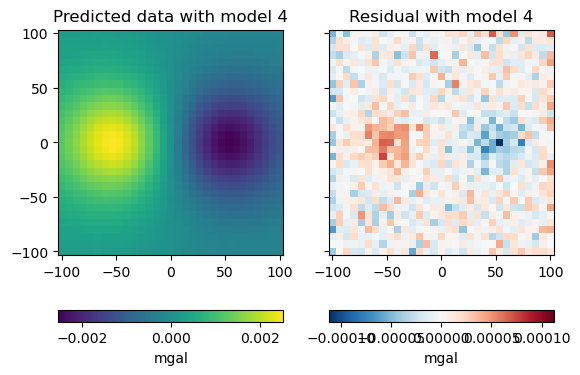

In [24]:
for i, model in enumerate(inversion.models):
    gz = gz.reshape(coordinates[0].shape)
    dpred = simulation(model).reshape(coordinates[0].shape)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
    tmp = axes[0].pcolormesh(*coordinates[:2], dpred)
    axes[0].set_title(f"Predicted data with model {i}")
    plt.colorbar(tmp, ax=axes[0], orientation="horizontal", label="mgal")

    residual = gz - dpred
    maxabs = vd.maxabs(residual)
    tmp = axes[1].pcolormesh(*coordinates[:2], residual, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r")
    axes[1].set_title(f"Residual with model {i}")
    plt.colorbar(tmp, ax=axes[1], orientation="horizontal", label="mgal")
    
    for ax in axes:
        ax.set_aspect("equal")
    plt.show()